In [2]:
import os
import sys
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import tensorflow as tf
windowSize=10
epochs=300

## Trial on my stock price data

In [3]:
#based on: https://www.youtube.com/watch?v=c0k-YLQGKjY
#format:
##         X           Y
## [[[1],[2],[3],[4]] [5]

def df_to_windowed_df(dataframe,windowSize=3):
  data=dataframe.to_numpy()
  X=[]
  Y=[]
  
  for i in range(0,len(data)-windowSize):
    # nth=[[a[0],a[1]] for a in data[i:i+windowSize]]
    nth=[[a[1]] for a in data[i:i+windowSize]]
    # print(nth)
    X.append(nth)
    Y.append((data[i+windowSize])[1])
  
  return np.array(X),np.array(Y)
    
## history of tesla share prices
filepath="TSLA.csv"
df=pd.read_csv(filepath)

df.Date = pd.to_datetime(df.Date).astype('int64') / 10**9
X,Y=df_to_windowed_df(df,windowSize=windowSize)

In [5]:
def splitDataset(X,Y,threshold=0.8,valsize=0.01): 
    #threshold means 80% is split train/val
    # valsize means 1% never sees the model in val or training; this is taken from the val side, so val is actually size = 1-threshold-valsize
    threshold_index=round(X.shape[0]*(threshold+valsize))
    valindex=round(X.shape[0]*(1-valsize))
    
    x_train=X[:threshold_index]
    y_train=Y[:threshold_index]
    
    x_val=X[threshold_index:valindex]
    y_val=Y[threshold_index:valindex]
    
    x_test=X[valindex:]
    y_test=Y[valindex:]
    
    return x_train,y_train,x_val,y_val,x_test,y_test

x_train_0,y_train_0,x_val_0,y_val_0,x_test_0,y_test_0=splitDataset(X,Y)

In [6]:
###Normalize the data!

def zscoreNorm_manual(inp,mean,std):
    return (inp-mean)/std


normalize=True
if normalize==True:
    # Order=2 makes it a minmax scaling operation (so that we can de-normalize later)
    # x_train=tf.keras.utils.normalize(x_train_0,axis=0,order=2)
    # y_train=tf.keras.utils.normalize(y_train_0,axis=0,order=2)

    # x_val=tf.keras.utils.normalize(x_val_0,axis=0,order=2)
    # y_val=tf.keras.utils.normalize(y_val_0,axis=0,order=2)

    # x_test=tf.keras.utils.normalize(x_test_0,axis=0,order=np.inf)
    # y_test=tf.keras.utils.normalize(y_test_0,axis=0,order=np.inf)
    
    unNormData={"xtrain":[np.mean(x_train_0,axis=0),np.std(x_train_0,axis=0)],"ytrain":[np.mean(y_train_0,axis=0),np.std(y_train_0,axis=0)],
                "xval":[np.mean(x_val_0,axis=0),np.std(x_val_0,axis=0)],"yval":[np.mean(y_val_0,axis=0),np.std(y_val_0,axis=0)],
                "xtest":[np.mean(x_test_0,axis=0),np.std(x_test_0,axis=0)],"ytest":[np.mean(y_test_0,axis=0),np.std(y_test_0,axis=0)]
                }
    
    
    x_train=zscoreNorm_manual(x_train_0,unNormData["xtrain"][0],unNormData["xtrain"][1])
    y_train=zscoreNorm_manual(y_train_0,unNormData["ytrain"][0],unNormData["ytrain"][1])
    
    x_val=zscoreNorm_manual(x_val_0,unNormData["xval"][0],unNormData["xval"][1])
    y_val=zscoreNorm_manual(y_val_0,unNormData["yval"][0],unNormData["yval"][1])
    
    x_test=zscoreNorm_manual(x_test_0,unNormData["xtest"][0],unNormData["xtest"][1])
    y_test=zscoreNorm_manual(y_test_0,unNormData["ytest"][0],unNormData["ytest"][1])


# print(x_train.shape,x_train_c.shape)
# n=1
# # print(x_train[1])

# print(x_train[n],'\n\nBru\n\n',x_train_c[n])


# print(x_tr_norm.shape,x_test_n.shape)
# # print(x_tr_norm[0],y_tr_norm[0])
# print((x_tr_norm.shape[1],x_tr_norm.shape[2]))


In [7]:
# NO LONGER NEEDED WITH THE MANUAL Z- SCORE NORMALIZATION PROCESS

# if y_train.shape[0]<y_train.shape[1]:
#     #transpose all
#     y_train=np.transpose(y_train)
    
# if y_val.shape[0]<y_val.shape[1]:
#     #transpose all
#     y_val=np.transpose(y_val)
    
# if y_test.shape[0]<y_test.shape[1]:
#     #transpose all
#     y_test=np.transpose(y_test)

In [104]:
# THIS IS JUST TO VALIDATE THAT THE NORMALIZATION AND DENORMALIZATION PROCESS WORKS

print(y_test_0[-4])
print("mean",unNormData['ytest'][0],np.mean(y_test_0,axis=0))
print("std",unNormData['ytest'][1],np.std(y_test_0,axis=0))
print(y_test[-4])
print(y_test[-4]*unNormData['ytest'][1]+unNormData['ytest'][0])

241.550003
mean 228.27176388235293 228.27176388235293
std 13.430881753780533 13.430881753780533
0.9886349504871121
241.550003


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
# x_train.shape
# print(x_train)

print(y_train)

[-0.52601099 -0.52342297 -0.52243952 ...  3.30763783  3.2137573
  3.38010221]


In [11]:
model=tf.keras.Sequential()

model.add(InputLayer((x_train.shape[1],x_train.shape[2])))
model.add(LSTM(64))
model.add(Dense(8,'relu'))
model.add(Dense(1,'linear'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [12]:
logspath=os.path.join('logs','model_init')
cp=ModelCheckpoint(logspath,save_best_only=True)
model.compile(loss='mse', optimizer=Adam())


In [13]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape

((2736, 10, 1), (2736,), (608, 10, 1), (608,))

In [14]:

history=model.fit(x_train,y_train,epochs=epochs,validation_data=(x_val,y_val),callbacks=cp)

Epoch 1/300
79/86 [==========================>...] - ETA: 0s - loss: 0.1741

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 13s 64ms/step - loss: 0.1623 - val_loss: 0.1538
Epoch 2/300
82/86 [===========================>..] - ETA: 0s - loss: 0.0094

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 50ms/step - loss: 0.0094 - val_loss: 0.1213
Epoch 3/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0083 - val_loss: 0.1332
Epoch 4/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0066 - val_loss: 0.1232
Epoch 5/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0062 - val_loss: 0.1220
Epoch 6/300
86/86 [==============================] - ETA: 0s - loss: 0.0060

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 51ms/step - loss: 0.0060 - val_loss: 0.1144
Epoch 7/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0056 - val_loss: 0.1225
Epoch 8/300
83/86 [===========================>..] - ETA: 0s - loss: 0.0060

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 50ms/step - loss: 0.0064 - val_loss: 0.1140
Epoch 9/300
81/86 [===========================>..] - ETA: 0s - loss: 0.0052

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 49ms/step - loss: 0.0050 - val_loss: 0.1098
Epoch 10/300
79/86 [==========================>...] - ETA: 0s - loss: 0.0046

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 47ms/step - loss: 0.0047 - val_loss: 0.1082
Epoch 11/300
85/86 [============================>.] - ETA: 0s - loss: 0.0070

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 5s 60ms/step - loss: 0.0070 - val_loss: 0.1046
Epoch 12/300
86/86 [==============================] - 1s 8ms/step - loss: 0.0046 - val_loss: 0.1066
Epoch 13/300
79/86 [==========================>...] - ETA: 0s - loss: 0.0049

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 47ms/step - loss: 0.0048 - val_loss: 0.1039
Epoch 14/300
82/86 [===========================>..] - ETA: 0s - loss: 0.0043

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 49ms/step - loss: 0.0043 - val_loss: 0.0967
Epoch 15/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0041 - val_loss: 0.0968
Epoch 16/300
86/86 [==============================] - 1s 8ms/step - loss: 0.0042 - val_loss: 0.0997
Epoch 17/300
82/86 [===========================>..] - ETA: 0s - loss: 0.0036

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 47ms/step - loss: 0.0037 - val_loss: 0.0920
Epoch 18/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0038 - val_loss: 0.0986
Epoch 19/300
81/86 [===========================>..] - ETA: 0s - loss: 0.0041

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 44ms/step - loss: 0.0041 - val_loss: 0.0917
Epoch 20/300
77/86 [=========================>....] - ETA: 0s - loss: 0.0036

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 46ms/step - loss: 0.0035 - val_loss: 0.0894
Epoch 21/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0042 - val_loss: 0.0902
Epoch 22/300
84/86 [============================>.] - ETA: 0s - loss: 0.0035

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 43ms/step - loss: 0.0034 - val_loss: 0.0851
Epoch 23/300
86/86 [==============================] - ETA: 0s - loss: 0.0035

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 51ms/step - loss: 0.0035 - val_loss: 0.0830
Epoch 24/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0933
Epoch 25/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0835
Epoch 26/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0838
Epoch 27/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0832
Epoch 28/300
80/86 [==========================>...] - ETA: 0s - loss: 0.0042

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 45ms/step - loss: 0.0042 - val_loss: 0.0794
Epoch 29/300
78/86 [==========================>...] - ETA: 0s - loss: 0.0033

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 45ms/step - loss: 0.0036 - val_loss: 0.0754
Epoch 30/300
86/86 [==============================] - 1s 9ms/step - loss: 0.0039 - val_loss: 0.0779
Epoch 31/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0037 - val_loss: 0.0795
Epoch 32/300
77/86 [=========================>....] - ETA: 0s - loss: 0.0038

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 5s 53ms/step - loss: 0.0037 - val_loss: 0.0696
Epoch 33/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0034 - val_loss: 0.0697
Epoch 34/300
84/86 [============================>.] - ETA: 0s - loss: 0.0039

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 48ms/step - loss: 0.0038 - val_loss: 0.0689
Epoch 35/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0726
Epoch 36/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0697
Epoch 37/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0697
Epoch 38/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0711
Epoch 39/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0734
Epoch 40/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0696
Epoch 41/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0716
Epoch 42/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0763
Epoch 43/300
83/86 [===========================>..] - ETA: 0s - loss: 0.0038

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 45ms/step - loss: 0.0037 - val_loss: 0.0676
Epoch 44/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0678
Epoch 45/300
79/86 [==========================>...] - ETA: 0s - loss: 0.0024

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 49ms/step - loss: 0.0027 - val_loss: 0.0671
Epoch 46/300
84/86 [============================>.] - ETA: 0s - loss: 0.0030

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 5s 57ms/step - loss: 0.0030 - val_loss: 0.0666
Epoch 47/300
86/86 [==============================] - 1s 8ms/step - loss: 0.0028 - val_loss: 0.0707
Epoch 48/300
84/86 [============================>.] - ETA: 0s - loss: 0.0028

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 5s 58ms/step - loss: 0.0028 - val_loss: 0.0643
Epoch 49/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0030 - val_loss: 0.0679
Epoch 50/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0034 - val_loss: 0.0667
Epoch 51/300
81/86 [===========================>..] - ETA: 0s - loss: 0.0028

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 46ms/step - loss: 0.0029 - val_loss: 0.0604
Epoch 52/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0662
Epoch 53/300
77/86 [=========================>....] - ETA: 0s - loss: 0.0039

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 43ms/step - loss: 0.0037 - val_loss: 0.0585
Epoch 54/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0633
Epoch 55/300
86/86 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0598
Epoch 56/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0635
Epoch 57/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0600
Epoch 58/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0598
Epoch 59/300
86/86 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0595
Epoch 60/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0665
Epoch 61/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0643
Epoch 62/300
84/86 [============================>.] - ETA: 0s - loss: 0.0029

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 45ms/step - loss: 0.0029 - val_loss: 0.0528
Epoch 63/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0028 - val_loss: 0.0544
Epoch 64/300
86/86 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0577
Epoch 65/300
86/86 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0574
Epoch 66/300
86/86 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0594
Epoch 67/300
86/86 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0567
Epoch 68/300
86/86 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0625
Epoch 69/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0589
Epoch 70/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0603
Epoch 71/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0600
Epoch 72/300

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 46ms/step - loss: 0.0029 - val_loss: 0.0500
Epoch 94/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0555
Epoch 95/300
86/86 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0580
Epoch 96/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0545
Epoch 97/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0034 - val_loss: 0.0697
Epoch 98/300
86/86 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0572
Epoch 99/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0577
Epoch 100/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0654
Epoch 101/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0571
Epoch 102/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0661
Epoch 103

INFO:tensorflow:Assets written to: logs\model_init\assets


INFO:tensorflow:Assets written to: logs\model_init\assets


86/86 [==============================] - 4s 44ms/step - loss: 0.0028 - val_loss: 0.0488
Epoch 107/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0501
Epoch 108/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0554
Epoch 109/300
86/86 [==============================] - 1s 7ms/step - loss: 0.0028 - val_loss: 0.0568
Epoch 110/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0556
Epoch 111/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0569
Epoch 112/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0584
Epoch 113/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0580
Epoch 114/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0539
Epoch 115/300
86/86 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0577
Epo

In [15]:
from tensorflow.keras.models import load_model
model=load_model(logspath)

In [16]:
train_predictions=model.predict(x_train).flatten()
yflat=y_train.flatten()


86/86 [==============================] - 1s 3ms/step


In [17]:
train_predictions.shape,y_train.shape,x_train.shape,yflat.shape
# print(y_train)

((2736,), (2736,), (2736, 10, 1), (2736,))

In [18]:
train_predictions=model.predict(x_train).flatten()
train_results=pd.DataFrame(data={'Train Predictions':train_predictions,'Actuals':yflat})
train_results

86/86 [==============================] - 0s 3ms/step


,Train Predictions,Actuals
0,-0.522700,-0.526011
1,-0.522212,-0.523423
2,-0.519961,-0.522440
3,-0.518895,-0.521573
4,-0.518100,-0.520951
...,...,...
2731,3.182306,3.025802
2732,3.087418,3.171055
2733,3.222336,3.307638
2734,3.341951,3.213757


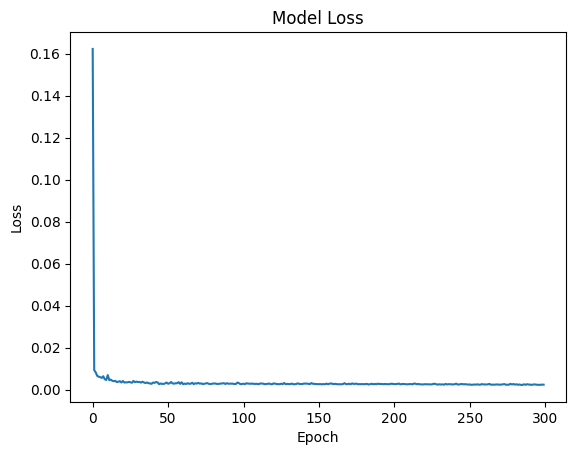

In [19]:
## Check for overfitting
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [20]:
## evaluate the model
testscore=model.evaluate(x_test,y_test)
print(testscore)

2/2 [==============================] - 0s 6ms/step - loss: 0.2939
0.2938760817050934


In [21]:
# print(x_train)
print(x_train.shape)
print(x_train[:,0])

(2736, 10, 1)
[[-0.52074446]
 [-0.51178909]
 [-0.51283101]
 ...
 [ 3.84484004]
 [ 3.8389049 ]
 [ 3.40590769]]


In [85]:
# Add dates here because we arent training with the date becasue that is kind of annoying to do.
def genDateSplit(dates,windowSize,threshold=0.8,valsize=0.01): 
    #threshold means 80% is split train/val
    # valsize means 1% never sees the model in val or training; this is taken from the val side, so val is actually size = 1-threshold-valsize
    threshold_index=round(X.shape[0]*(threshold+valsize))+windowSize
    valindex=round(X.shape[0]*(1-valsize))+windowSize
    
    a=dates[windowSize:threshold_index]
    b=dates[threshold_index:valindex]
    c=dates[valindex:]
    
    print(len(a),len(b),len(c))
    
    return a,b,c

unixdates=df.Date.tolist()
ndates=[]
for i in unixdates:
    ndates.append(datetime.utcfromtimestamp(i).strftime('%Y-%m-%d'))
# print(ndates)

trainDates,val_dates,testDates=genDateSplit(ndates,windowSize)


2736 608 34


In [75]:
# compare lengths of the data things
print("train", len(trainDates),y_train.shape[0])
print("val", len(val_dates),y_val.shape[0])
print("test", len(testDates),y_test.shape[0])

train 2736 2736
val 608 608
test 34 34


In [24]:
df.Open[3379]

245.139999

In [76]:
x_test[-10]
# x_test[-1,:],x_test[33,:] # these are equal
x_test.shape,x_test[(x_test.shape[0]-windowSize-1):-1,:].shape

x_set4Predict=x_test[-2:-1,:]
x_set4Predict.shape,x_test.shape

((1, 10, 1), (34, 10, 1))

In [77]:
val_predictions=model.predict(x_val)
test_predictions=model.predict(x_test)
future_predict=model.predict(x_set4Predict)

1/1 [==============================] - 0s 21ms/step


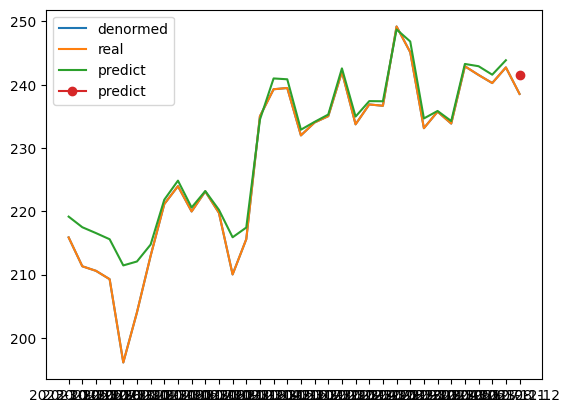

In [139]:
## un-normalize data so that we can have the context to it
def unNormalize(normddata,meann,stddev):
    # print(meann,stddev)
    orig=normddata*stddev + meann
    return orig

normed_ytrain=unNormalize(y_train,unNormData['ytrain'][0],unNormData['ytrain'][1])
normed_yval=unNormalize(y_val,unNormData['yval'][0],unNormData['yval'][1])
normed_ytest=unNormalize(y_test,unNormData['ytest'][0],unNormData['ytest'][1])

normValPreedict=unNormalize(val_predictions,unNormData['yval'][0],unNormData['yval'][1])
normTestPredictions=unNormalize(test_predictions,unNormData['ytest'][0],unNormData['ytest'][1])
normed_futurePrediction=unNormalize(future_predict,unNormData['ytest'][0],unNormData['ytest'][1])


#  THIS SECTION VALIDATES THAT THE DE-NORMALIZATION PROCEDURE IS WORKING

plt.plot(testDates,normed_ytest,label='denormed')
plt.plot(testDates,df.Open[-normed_ytest.shape[0]:df.shape[0]].tolist(),label="real")
plt.plot(testDates[:-1],normTestPredictions.flatten()[1:],label="predict")
plt.plot(testDates[len(testDates)-1],normed_futurePrediction,label="predict",marker='o')
plt.legend() 
plt.show()

In [127]:
normTestPredictions[-1],normed_ytest[-1],normTestPredictions[-2],normed_ytest[-2]

(array([243.87389], dtype=float32),
 238.550003,
 array([241.59123], dtype=float32),
 242.740005)

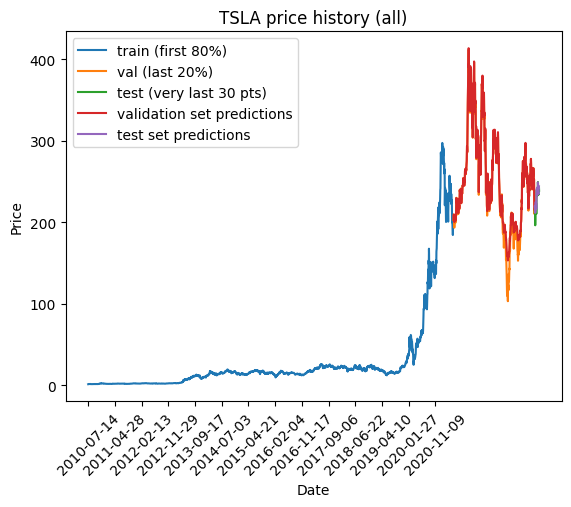

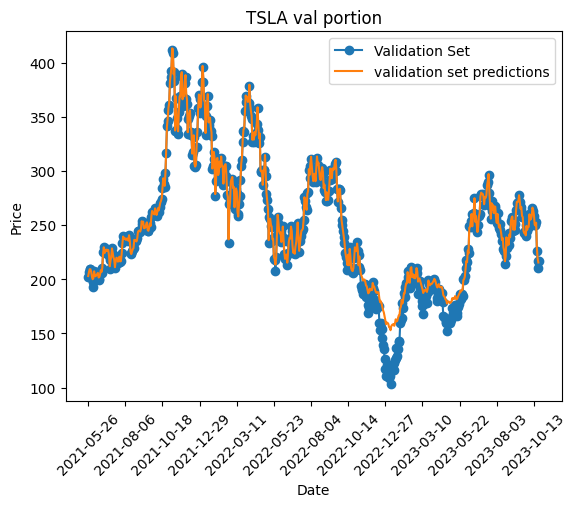

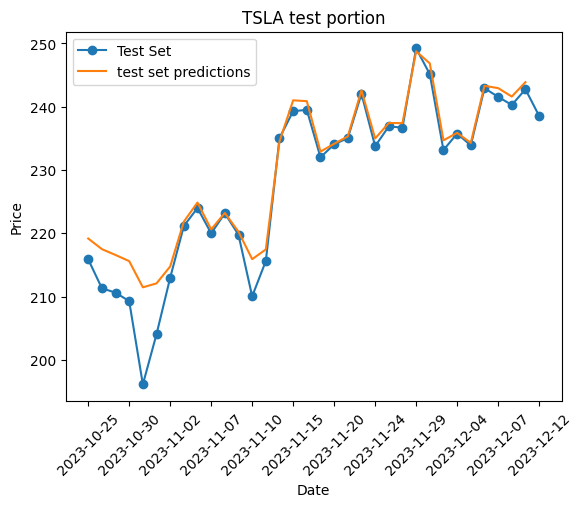

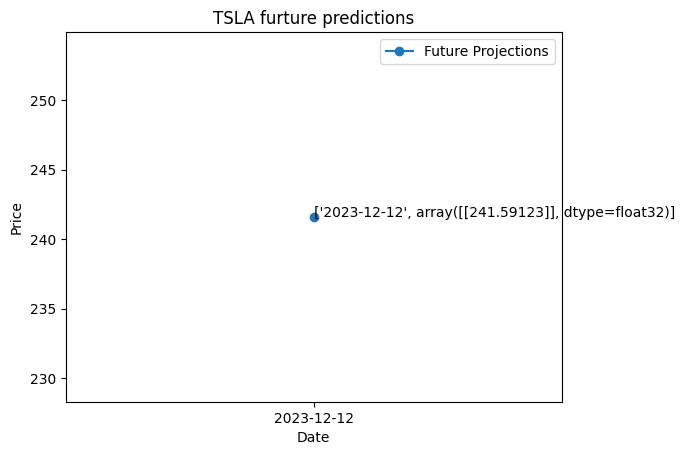

In [136]:
#Plot the real stock prices
plt.plot(trainDates,normed_ytrain.flatten(),label="train (first 80%)")
plt.xticks(trainDates[::200],rotation=45)
plt.plot(val_dates,normed_yval.flatten(),label="val (last 20%)")
plt.plot(testDates,normed_ytest.flatten(),label="test (very last 30 pts)")

plt.plot(val_dates[:-1],normValPreedict[1:],label="validation set predictions")
plt.plot(testDates[:-1],normTestPredictions[1:],label="test set predictions")
plt.title('TSLA price history (all)')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend() 
plt.show()

plt.plot(val_dates,normed_yval,label="Validation Set",marker='o')

plt.plot(val_dates[:-1],normValPreedict[1:],label="validation set predictions")
plt.xticks(val_dates[::50],rotation=45)
plt.title('TSLA val portion')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend() 
plt.show()

plt.plot(testDates,normed_ytest,label="Test Set",marker='o')
plt.plot(testDates[:-1],normTestPredictions[1:],label="test set predictions")
plt.xticks(testDates[::3],rotation=45)
plt.title('TSLA test portion')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend() 
plt.show()

plt.plot(testDates[-1],normed_futurePrediction,label="Future Projections",marker='o')
annot=[testDates[-1],normed_futurePrediction]
plt.annotate(annot,annot)
plt.title('TSLA furture predictions')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend() 
plt.show()

